<h1> Feedforward Fully-connected Neuralnetwork </h1>


<h3>Proto</h3>
단순하게 학습정도만 구현할것임. 버전관리하면서 기능 추가해볼것  

batch_size : size of mini-batch INT  
n_iteration : number of iterations INT  
n_neurons : number of neurons to hidden layer INT    
n_layers : number of hidden layers INT    
learning_rate : learning rate FLOAT    
hidden_activation : activation function. [ 'sigmoid', 'relu' ]   
output_activation : activation function for last layer. [ 'sigmoid', 'relu', 'softmax']  
cost_function : cost function [ 'crossentropy', 'mse' ]  
optimizer : gradient descent algorithm. [ 'minibatchSGD' ]  
kernel_initializer : kernel initializer. [ 'he', 'savier' ]  
early_stopping : early stopping. None if not use this, Int if uses  
momentum : momentum BOOL  
beta : impact of momentum FLOAT  

앞으로구현할것:  
Crossentropy backpropagation


In [8]:
import pandas as pd
import numpy as np
from collections import Counter
from tqdm import trange

In [9]:
#preprocess

s = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
df = pd.read_csv(s,
                 header=None,
                 encoding='utf-8')

y = df.iloc[0:100,4].values
y = np.where(y == 'Iris-setosa', 0, 1)
X = df.iloc[0:100, [0, 2]].values

In [16]:
class FullyconnectedNN(object):
    def __init__(self, early_stopping = None, n_iteration = 100, shuffle = True, batch_size = 32, n_neurons = 2, n_layers = 2, learning_rate = 0.1, hidden_activation = 'relu', output_activation = 'relu',
                 cost_function = 'mse', optimizer = 'minibatchSGD', random_state = None, kernel_initializer = 'he', momentum = True, beta = .9):
        self.early_stopping = int(early_stopping) if early_stopping != None else early_stopping
        self.n_iteration = n_iteration
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.n_layers = n_layers
        self.n_neurons = n_neurons
        self.hidden_activation = hidden_activation
        self.learning_rate = learning_rate
        self.output_activation = output_activation
        self.cost_function_ = cost_function
        self.optimizer = optimizer
        self.random_state = random_state
        self.kernel_initializer = kernel_initializer
        self.momentum = momentum
        self.beta = beta
        
    def fit(self, X, y):   
        def mse(y_hat, y):
            return np.square(np.subtract(y_hat, y)).mean()
        def cross_entropy(y_hat, y):
            #add delta to prevent y_hat to be zero
            delta = 1e-7 
            return -np.sum(y*np.log(y_hat+delta))
        
        
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        assert X.shape[0] == len(y), "X and y don't match."
        rgen = np.random.RandomState(self.random_state)
        
        self.w_ = []
        self.b_ = []
        
        if self.kernel_initializer == 'he':
            scale = [np.sqrt(2/X.shape[1]), np.sqrt(2/self.n_neurons)]
        else:
            scale = [.01, .01]
        
        self.w_.append(rgen.normal(loc = .0, scale = scale[0], size = X.shape[1] * self.n_neurons).reshape(X.shape[1], self.n_neurons))
        self.b_.append(rgen.normal(loc = .0, scale = scale[0], size = self.n_neurons))
        
        for _ in range(self.n_layers - 1):
            self.w_.append(rgen.normal(loc = .0, scale = scale[1], size = np.power(self.n_neurons,2)).reshape(self.n_neurons,self.n_neurons))
            self.b_.append(rgen.normal(loc = .0, scale = scale[1], size = self.n_neurons))
            
        if self.cost_function_ in ['crossentropy']:
            self.w_.append(rgen.normal(loc = .0, scale = scale[1], size = len(Counter(y)) * self.n_neurons).reshape(len(Counter(y)), self.n_neurons))
            self.b_.append(rgen.normal(loc = .0, scale = scale[1], size = len(Counter(y))))
        else:
            self.w_.append(rgen.normal(loc = .0, scale = scale[1], size = self.n_neurons))
            self.b_.append(rgen.normal(loc = .0, scale = scale[1], size = 1))
        
        if self.momentum:
            beta_rev = (1 - self.beta)
            self._V_W = []
            self._V_b = []
            
            self._V_W.append(np.zeros(X.shape[1] * self.n_neurons).reshape(X.shape[1], self.n_neurons))
            self._V_b.append(np.zeros(self.n_neurons))

            for _ in range(self.n_layers - 1):
                self._V_W.append(np.zeros(np.power(self.n_neurons,2)).reshape(self.n_neurons,self.n_neurons))
                self._V_b.append(np.zeros(self.n_neurons))

            if self.cost_function_ in ['crossentropy']:
                self._V_W.append(np.zeros(len(Counter(y)) * self.n_neurons).reshape(len(Counter(y)), self.n_neurons))
                self._V_b.append(np.zeros(len(Counter(y))))
            else:
                self._V_W.append(np.zeros(self.n_neurons))
                self._V_b.append(np.zeros(1))
        
                        
        self.cost_ = []
        if self.early_stopping != None:
            es = 0
            
        def create_minibatches(y):
            indices = np.arange(len(y))
            if self.shuffle:
                rgen.shuffle(indices)
            cut = [x for x in range(0, len(indices), self.batch_size)] + [len(indices)]
            mini_batches = []
            for i in range(1,len(cut)):
                mini_batches.append(indices[cut[i-1]:cut[i]])
            return mini_batches
        
        for iterzz in trange(self.n_iteration):
            batches = create_minibatches(y)
            cost = []
            cost_ = []
            for batch in batches:
                X_batch = X[tuple(batch),:]
                y_batch = [y[int(batch_idx)] for batch_idx in batch]
                
                #forward-propagation
                self._y_hat = self.predict(X_batch)
                if self.cost_function_ == 'crossentropy':
                    cost.append(cross_entropy(self._y_hat, y_batch))
                if self.cost_function_ == 'mse':
                    cost.append(mse(self._y_hat, y_batch))
                
                #back-propagation
                self._d = []
                if self.momentum:
                    for i in range(1,self.n_layers + 1):
                        if self.cost_function_ == 'mse':
                            if i == 1:
                                self._d.append( ((self._y_hat - y_batch) * self._o_prime[-1]).mean(axis = 0) )
                                self._V_W[-1] = (self.beta * self._V_W[-1]) + (beta_rev * (self._d[-1] * self._o[-1].mean(axis = 0)))
                                self.w_[-1] = self.w_[-1] - (self.learning_rate * self._V_W[-1])
                                self._V_b[-1] = (self.beta * self._V_b[-1]) + (beta_rev * (self._d[-1] * self._d[-1]))
                                self.b_[-1] = self.b_[-1] - (self.learning_rate * self._V_b[-1])
                            else:
                                self._d.append( self._o_prime[-i].mean(axis = 0) *  np.sum(np.dot(self._d[-1], self.w_[-(i-1)].T), axis = 0) )
                                self._V_W[-i] = (self.beta * self._V_W[-i]) + (beta_rev * np.dot(self._d[-1][:,None], self._o[-i].mean(axis = 0)[:,None].T).T )
                                self.w_[-i] = self.w_[-i] - (self.learning_rate * self._V_W[-i] )
                                self._V_b[-i] = (self.beta * self._V_b[-i]) + (beta_rev * self._d[-1])
                                self.b_[-i] = self.b_[-i] - (self.learning_rate * self._V_b[-i])

                    else:
                        self._d.append( self._o_prime[0].mean(axis = 0) * np.sum(np.dot(nn._d[-1], nn.w_[1].T), axis = 0) )
                        self._V_W[0] = (self.beta * self._V_W[0]) + (beta_rev * np.dot(self._d[-1][:,None], X_batch.mean(axis = 0)[:,None].T).T )
                        self.w_[0] = self.w_[0] - (self.learning_rate * self._V_W[0])
                        self._V_b[0] = (self.beta * self._V_b[0]) + (beta_rev * self._d[-1])
                        self.b_[0] = self.b_[0] - (self.learning_rate * self._V_b[0])
            
                else:
                    for i in range(1,self.n_layers + 1):
                        if self.cost_function_ == 'mse':
                            if i == 1:
                                self._d.append( ((self._y_hat - y_batch) * self._o_prime[-1]).mean(axis = 0) )
                                self.w_[-1] = self.w_[-1] - (self.learning_rate * self._d[-1] * self._o[-1].mean(axis = 0))
                                self.b_[-1] = self.b_[-1] - (self.learning_rate * self._d[-1])
                            else:
                                self._d.append( self._o_prime[-i].mean(axis = 0) *  np.sum(np.dot(self._d[-1], self.w_[-(i-1)].T), axis = 0) )
                                self.w_[-i] = self.w_[-i] - (self.learning_rate * np.dot(self._d[-1][:,None], self._o[-i].mean(axis = 0)[:,None].T) ).T
                                self.b_[-i] = self.b_[-i] - (self.learning_rate * self._d[-1])

                    else:
                        self._d.append( self._o_prime[0].mean(axis = 0) * np.sum(np.dot(nn._d[-1], nn.w_[1].T), axis = 0) )
                        self.w_[0] = self.w_[0] - (self.learning_rate * np.dot(self._d[-1][:,None], X_batch.mean(axis = 0)[:,None].T) ).T
                        self.b_[0] = self.b_[0] - (self.learning_rate * self._d[-1])
            
            cost_ = sum(cost) / len(cost)
            if (self.early_stopping != None):
                if iterzz == 0:
                    self._w_early = self.w_
                    self._b_early = self.b_
                else:
                    if es == 0:
                        if self.cost_[-1] < cost_:
                            es = 1
                            es_ = iterzz
                            self._w_early = self.w_
                            self._b_early = self.b_
                    else:
                        if self.cost_[es_] < cost_:
                            es = es + 1
                        else:
                            es = 0
                            
                        if es > self.early_stopping:
                            self.w_ = self._w_early
                            self.b_ = self._b_early
                            self.cost_ = self.cost_[:es_]
                            self.n_iteration = es_ + 1
                            return self
                

            self.cost_.append(cost_)
        
        return self
            
        
    def predict(self, X):
        def softmax(z):
            assert len(z.shape) == 2
            s = np.max(z, axis=1)
            s = s[:, np.newaxis]
            e_x = np.exp(z - s)
            div = np.sum(e_x, axis=1)
            div = div[:, np.newaxis]
            return e_x / div
        self._o = []
        self._o_prime = []
        
        if self.hidden_activation == 'sigmoid':
            hidden_activation = lambda x:1/(1+np.exp(-x))
            def hidden_activation_prime(x):
                rev = (1-hidden_activation(x))
                return hidden_activation(x) * rev
        if self.hidden_activation == 'relu':
            hidden_activation = lambda x:np.maximum(x,0)
            hidden_activation_prime = lambda x:np.heaviside(x,0)
        
        if self.output_activation == 'sigmoid':
            output_activation = lambda x:1/(1+np.exp(-x))
            def output_activation_prime(x):
                rev = (1-output_activation(x))
                return output_activation(x) * rev
        if self.output_activation == 'relu':
            output_activation = lambda x:np.maximum(x,0)
            output_activation_prime = lambda x:np.heaviside(x,0)
        if self.output_activation == 'softmax':
            def output_activation(z):
                assert len(z.shape) == 2
                s = np.max(z, axis=1)
                s = s[:, np.newaxis]
                e_x = np.exp(z - s)
                div = np.sum(e_x, axis=1)
                div = div[:, np.newaxis]
                return e_x / div
            
        
        for i in range(self.n_layers):
            if i == 0:
                o_ = np.matmul(X, self.w_[i]) + self.b_[i]
                self._o.append(hidden_activation(o_))
                self._o_prime.append(hidden_activation_prime(o_))
                
            else:
                o_ = np.matmul(self._o[i-1], self.w_[i]) + self.b_[i]
                self._o.append(hidden_activation(o_))
                self._o_prime.append(hidden_activation_prime(o_))
                    
        o_ = np.matmul(self._o[self.n_layers-1], self.w_[self.n_layers]) + self.b_[self.n_layers]
        self._o_prime.append(output_activation_prime(o_))
        return output_activation(o_)

 58%|██████████████████████████████████████████▌                               | 11512/20000 [00:08<00:06, 1284.02it/s]


Text(0.5, 1.0, 'num iteration : 11413')

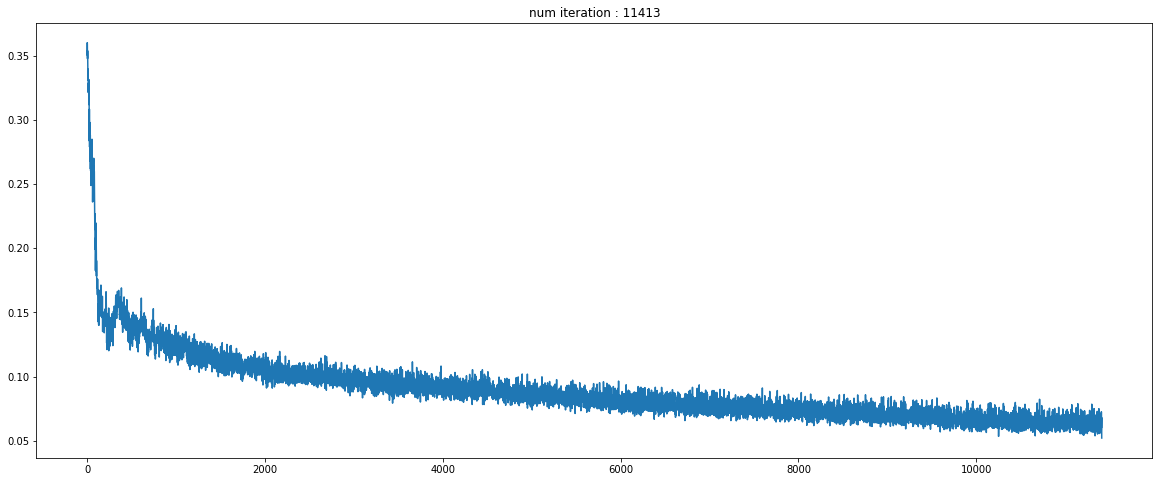

In [51]:
nn = FullyconnectedNN(output_activation='sigmoid', hidden_activation='relu', learning_rate=0.01, n_layers= 3, n_neurons = 5, n_iteration = 20000, random_state = 42, early_stopping=100)
nn.fit(X,y) 

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (20,8))
plt.plot(nn.cost_)
plt.title(f'num iteration : {nn.n_iteration}')

  2%|█▍                                                                          | 389/20000 [00:00<00:13, 1506.49it/s]


Text(0.5, 1.0, 'num iteration : 290')

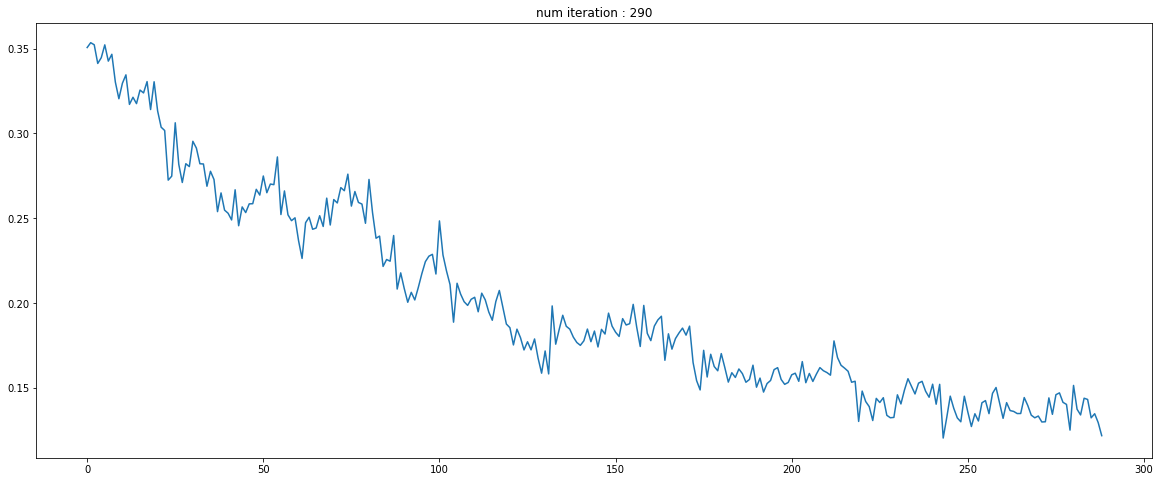

In [52]:
nn2 = FullyconnectedNN(output_activation='sigmoid', hidden_activation='relu', learning_rate=0.01, n_layers= 3, n_neurons = 5, n_iteration = 20000, random_state = 42, early_stopping=100,
                       momentum = False)
nn2.fit(X,y) 

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (20,8))
plt.plot(nn2.cost_)
plt.title(f'num iteration : {nn2.n_iteration}')